In [1]:
#!pip install qiskit matplotlib pylatexenc networkx scipy

En primer lugar vamos a importar las bibliotecas necesarias

In [2]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import Aer
from qiskit.visualization import plot_histogram
from networkx import Graph, draw, complete_graph
from scipy.optimize import minimize
import numpy as np

Vamos a construir el circuito a partir del grafo y un vector que contiene los parámetros γ y β

In [3]:
def int_to_binary_var(low, high):
    diff = high - low
    ans = [2**p for p in range(diff.bit_length()-1)]
    ans += [diff - sum(ans)]
    return ans

In [4]:
def create_matrix(size, data, functions):
    """
    
    size: (int) the number of qbits to use
    data: (dict) the data for the problem
    functions: (iterable(function: array, dict -> array)) the decomposition of the functions.
    """
    mat = np.zeros((size, size))
    for f in functions:
        f(mat, data)
    return mat

In [5]:
def apply_linear_function(eq, keys, size, offset=0, indexes=None, start_i=0, end_i=None):
    if end_i == None:
        end_i = size
    assert(start_i - offset >= 0 and start_i < end_i and end_i <= size)
    
    if indexes == None:
        indexes = range(start_i, end_i)
        
    def linear_f(matrix,data):
        for i in indexes:
            matrix[i,i] += eq(i - offset, *[data[k] for k in keys])
        return matrix
    
    return linear_f

In [6]:
def apply_quadratic_function(eq, keys, size, offset_i=0, indexes_i =None, start_i=0, end_i=None, start_j=0, end_j=None, indexes_j=None, offset_j=0):
    if end_i == None:
        end_i = size
    if end_j == None:
        end_j = size
    assert(start_i - offset_i >= 0 and start_i < end_i and end_i <= size)
    assert(start_j - offset_j >= 0 and start_j < end_j and end_j <= size)
    
    if indexes_i == None:
        indexes_i = range(start_i, end_i)
    
    if indexes_j == None:
        indexes_j = range(start_j, end_j)
    
    def quadratic_f(matrix, data):
        for i in indexes_i:
            for j in indexes_j:
                if i < j:
                    val = eq(i-offset_i, j-offset_j, *[data[k] for k in keys[0]], *[data[k] for k in keys[1]])
                    matrix[i,j] += val
                    matrix[j,i] += val
        return matrix
    
    return quadratic_f

In [7]:
def pack_TSP_data(g):
    P = sum([n[2]['w'] for n in g.edges(data=True)])
    size = len(g.nodes)
    w = np.zeros((size, size))
    for j in range(size):
        for k in range(size):
            if j != k:
                w[j,k] = P if not (j,k) in g.edges else g[j][k]['w']
            else:
                w[j,k] = 0
    P = w.sum()
    data = {'w' : w, "size" : size, "P": P}
    n = len(g.nodes)
    mat = np.zeros((n, n), dtype=int)
    pairs = []
    loop = 0
    cnt = 0
    for a in range(n**2):
        mat[cnt, a%n] = a
        pairs.append((cnt, a%n))
        if loop == n-1:
            cnt += 1
            loop = 0
        else:
            loop +=1

    data['map'] = mat
    data['pairs'] = pairs
    #print(w)
    #print(data["map"], data["pairs"])
    return data

In [8]:
def weight_TSP(matrix, data):
    n = data["size"]
    last_done = False
    for i in range(data["size"]):
        for j in range(data["size"]):
            for k in range(data["size"]):
                if j != k:
                    matrix[data['map'][i,j],data["map"][(i+1)%n,k]] += data['w'][j,k]
                    matrix[data["map"][(i+1)%n,k], data['map'][i,j]] += data['w'][j,k]
                  
                #if not last_done:
                 #   matrix[data['map'][n-1,k], data['map'][0,j]] += data['w'][j,k]
                        
        last_done = True
    return matrix

In [9]:
def three_sums(matrix, data):
    n = data["size"]
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if j < k:
                    matrix[data["map"][i,j],data["map"][i,k]] += 2*data["P"]
                    matrix[data["map"][i,k],data["map"][i,j]] += 2*data["P"]

            for l in range(n):
                if i < l:
                    matrix[data["map"][i,j],data["map"][l,j]] += 2*data["P"]
                    matrix[data["map"][l,j],data["map"][i,j]] += 2*data["P"]
                
    return matrix

In [10]:
def TSP_QUBO_matrix(G):
    data = pack_TSP_data(G)
    f = [weight_TSP, three_sums]
    
    eq1 = lambda i: -2 * data["P"]
    f.append(apply_linear_function(eq1, [], data["size"]**2))
    
    return create_matrix(data["size"]**2, data, f) , 2*data["P"]*data["size"] #, data

In [11]:
def QUBO_to_Ising(matrix, c):
    size = matrix.shape[0]
    h = np.zeros(size)
    J = np.zeros((size,size))
    
    for i in range(size):
        h[i] += 1/4*(np.sum(matrix[i], axis=0) + matrix[i,i])
        for j in range(size):
            if i > j:
                J[i,j] = 1/4*matrix[i,j]
                J[j,i] = 1/4*matrix[i,j]
    J[0,0] = c + 1/4*np.sum(matrix) + 1/4* np.sum(np.diagonal(matrix))
    
    return h, J

In [12]:
from dimod import Binary, ExactSolver
from networkx import Graph, draw
from dwave.samplers import SimulatedAnnealingSampler, SteepestDescentSampler
from dwave.system import DWaveSampler, EmbeddingComposite

In [13]:
def QUBO_TSP(G):
    P = sum([n[2]['w'] for n in G.edges(data=True)])
    n = len(g.nodes())
    w = np.zeros((n, n))
    for j in range(len(g)):
        for k in range(len(g)):
            if j != k:
                w[j,k] = P if not (j,k) in g.edges else g[j][k]['w']
            else:
                w[j,k] = 0
    P = w.sum()
    keys = [f'x{i}_{j}' for i in range(n) for j in range(n)]
    var = [[Binary(f'x{i}_{j}') for j in range(n)] for i in range(n)]
    qubo = (sum([(var[i][j]*var[((i+1) % n)][k]*w[j,k]) for i in range(n) for j in range(n) for k in range(n)])
           # + sum([var[0][j]*var[n-1][k]*g[j][k]['w'] if j != k else 0 for j in range(n) for k in range(n)])
            + sum([P * (1 - sum([var[i][j] for i in range(n)]))**2 for j in range(n)])
            + sum([P * (1 - sum([var[i][j] for j in range(n)]))**2 for i in range(n)])
           )

    return qubo, keys

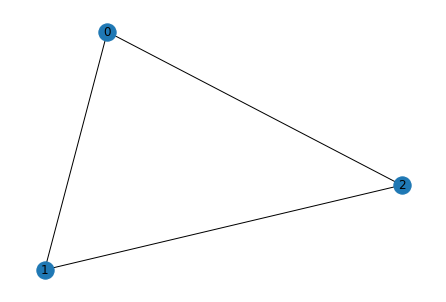

In [14]:
G = Graph()
G.add_edge(0,1, w=1)
G.add_edge(0,2, w=10)
G.add_edge(1,2, w=1)
draw(G, with_labels=True)

p_node = sum([n[2]['w'] for n in G.edges(data=True)])


In [15]:
g = G

In [16]:
def QUBO_TSP_t(g):
    P = sum([n[2]['w'] for n in g.edges(data=True)])
    n = len(g.nodes)
    
    w = np.zeros((n, n))
    for j in range(len(g)):
        for k in range(len(g)):
            if j != k:
                w[j,k] = P if not (j,k) in g.edges else g[j][k]['w']
            else:
                w[j,k] = 0
    P = w.sum()
    keys = [f'x{i}_{j}' for i in g for j in range(n)]
    var = [[Binary(f'x{i}_{j}') for j in range(n)] for i in range(n)]
    qubo = (sum([(var[i][j]*var[((i+1) % n)][k]*g[j][k]['w']) if j != k else 0 for i in range(n) for j in range(n) for k in range(n)])
           # + sum([var[0][j]*var[(n-1)][k]*g[j][k]['w'] if j != k else 0 for j in range(n) for k in range(n)])    
            + sum([2*P*(-var[i][j]) for i in range(n) for j in range(n)])         
            + sum([2*P*var[i][j]*var[i][k] if k > j else 0 for i in range(n) for j in range(n) for k in range(n)])
            + sum([2*P*var[i][j]*var[l][j] if l > i else 0 for i in range(n) for j in range(n) for l in range(n)])
            + 2*P*n
            )
    return qubo, keys

In [17]:
def obtener_circuito_knapsack_b(g, theta):
    nqubits = len(g.nodes)**2
    
    circuito = QuantumCircuit(nqubits)
    it = len(theta)//2
    

    gamma = theta[:it]
    beta = theta[it:]
    
    Q, C = TSP_QUBO_matrix(g)
    h, J = QUBO_to_Ising(Q, C)

    # Preparamos una superposición de todos los estados con puertas de Hadamard
    for i in range(0, nqubits):
        circuito.h(i)
  
  # Repetimos p veces los circuitos con el Hamiltoniano del problema y de mezcla
    for cnt in range(0,it):
        # Circuito con el Hamiltoniano del problema
        for i in range(nqubits):
            circuito.rz(2*gamma[cnt]*h[i], i)
            
        for i in range(nqubits):    
            for j in range(nqubits):
                if i != j:
                    circuito.rzz(2*gamma[cnt]*J[i,j], i ,j)
        
        # Circuito con el Hamitoniano de mezcla
        for qbit in range(0,nqubits):
            circuito.rx(beta[cnt], qbit)

    # Medida para obtener una solución
    circuito.measure_all()

    return circuito

In [18]:
import math
def funcion_objetivo(g, ejecuciones=10000):
    
    data = pack_TSP_data(g)
    n = len(g.nodes)
    P = sum([g[j][k]["w"] for j,k,_ in g.edges(data=True)])
    def calculate_value(solucion):
        obj = 0
        var = np.zeros((n,n))
        for cnt,bit in enumerate(solucion):
            a, b = data["pairs"][cnt]
            var[a,b] = int(bit)
        obj = (sum([(var[i,j]*var[(i+1)% n, k]*g[j][k]['w']) if j != k else 0 for i in range(n) for j in range(n) for k in range(n)])
                + sum([var[0,j]*var[n-1,k]*g[j][k]['w'] if j != k else 0 for j in range(n) for k in range(n)])
                + sum([P * (1 - sum([var[i,j] for i in range(n)]))**2 for j in range(n)])
                + sum([P*(1 - sum([var[i,j] for j in range(n)]))**2 for i in range(n)])
              )
        return obj

    def ejecuta_calcula_promedio(theta):
        histograma = ejecuta_circuito(g, theta, ejecuciones=ejecuciones)
        suma = 0
        ejecs = 0
        best = math.inf
        for solucion, veces in histograma.items():
            objective_value = calculate_value(solucion[::-1])
            #if objective_value < best:
             #   suma = objective_value * veces
              #  ejecs = veces
               # best = veces
            #elif objective_value == best:
            suma += objective_value * veces
            ejecs += veces

        return suma/ejecs

    return ejecuta_calcula_promedio


In [19]:
entorno = Aer.get_backend('qasm_simulator')

def ejecuta_circuito(G, theta, ejecuciones=1e8):      
    circuito = obtener_circuito_knapsack_b(G, theta)
    histograma = entorno.run(circuito, nshots=ejecuciones).result().get_counts()
    return histograma

Ahora solo nos queda utilizar un algoritmo de optimización clásico para resolver el problema. Aquí usaremos SLSQP de SciPy.

In [20]:
def maximiza(G, theta, ejecuciones=1000):
  objetivo = funcion_objetivo(G, ejecuciones=ejecuciones)
  return minimize(objetivo,theta, method='SLSQP')
  

In [21]:
Q, C= TSP_QUBO_matrix(G)
Q

array([[-48.,  48.,  48.,  48.,   1.,  10.,  48.,   1.,  10.],
       [ 48., -48.,  48.,   1.,  48.,   1.,   1.,  48.,   1.],
       [ 48.,  48., -48.,  10.,   1.,  48.,  10.,   1.,  48.],
       [ 48.,   1.,  10., -48.,  48.,  48.,  48.,   1.,  10.],
       [  1.,  48.,   1.,  48., -48.,  48.,   1.,  48.,   1.],
       [ 10.,   1.,  48.,  48.,  48., -48.,  10.,   1.,  48.],
       [ 48.,   1.,  10.,  48.,   1.,  10., -48.,  48.,  48.],
       [  1.,  48.,   1.,   1.,  48.,   1.,  48., -48.,  48.],
       [ 10.,   1.,  48.,  10.,   1.,  48.,  48.,  48., -48.]])

In [22]:
qubo, keys = QUBO_TSP(g)
(qubo.to_numpy_matrix(keys))#.all()

/tmp/ipykernel_95376/2648306381.py:2: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0 and will be removed in 0.12.0
  (qubo.to_numpy_matrix(keys))#.all()


array([[-48.,  48.,  48.,  48.,   1.,  10.,  48.,   1.,  10.],
       [  0., -48.,  48.,   1.,  48.,   1.,   1.,  48.,   1.],
       [  0.,   0., -48.,  10.,   1.,  48.,  10.,   1.,  48.],
       [  0.,   0.,   0., -48.,  48.,  48.,  48.,   1.,  10.],
       [  0.,   0.,   0.,   0., -48.,  48.,   1.,  48.,   1.],
       [  0.,   0.,   0.,   0.,   0., -48.,  10.,   1.,  48.],
       [  0.,   0.,   0.,   0.,   0.,   0., -48.,  48.,  48.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., -48.,  48.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -48.]])

In [23]:
qubo_t, keys = QUBO_TSP_t(g)
(qubo_t.to_numpy_matrix(keys)== qubo.to_numpy_matrix(keys)).all()

/tmp/ipykernel_95376/2310933831.py:2: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0 and will be removed in 0.12.0
  (qubo_t.to_numpy_matrix(keys)== qubo.to_numpy_matrix(keys)).all()


True

In [24]:
pack_TSP_data(g)

{'w': array([[ 0.,  1., 10.],
        [ 1.,  0.,  1.],
        [10.,  1.,  0.]]),
 'size': 3,
 'P': 24.0,
 'map': array([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]]),
 'pairs': [(0, 0),
  (0, 1),
  (0, 2),
  (1, 0),
  (1, 1),
  (1, 2),
  (2, 0),
  (2, 1),
  (2, 2)]}

In [25]:
qubo.to_ising()

({'x0_0': 29.5,
  'x1_0': 29.5,
  'x1_1': 25.0,
  'x1_2': 29.5,
  'x0_1': 25.0,
  'x0_2': 29.5,
  'x2_0': 29.5,
  'x2_1': 25.0,
  'x2_2': 29.5},
 {('x1_0', 'x0_0'): 12.0,
  ('x1_1', 'x0_0'): 0.25,
  ('x1_1', 'x1_0'): 12.0,
  ('x1_2', 'x0_0'): 2.5,
  ('x1_2', 'x1_0'): 12.0,
  ('x1_2', 'x1_1'): 12.0,
  ('x0_1', 'x0_0'): 12.0,
  ('x0_1', 'x1_0'): 0.25,
  ('x0_1', 'x1_1'): 12.0,
  ('x0_1', 'x1_2'): 0.25,
  ('x0_2', 'x0_0'): 12.0,
  ('x0_2', 'x1_0'): 2.5,
  ('x0_2', 'x1_1'): 0.25,
  ('x0_2', 'x1_2'): 12.0,
  ('x0_2', 'x0_1'): 12.0,
  ('x2_0', 'x0_0'): 12.0,
  ('x2_0', 'x1_0'): 12.0,
  ('x2_0', 'x1_1'): 0.25,
  ('x2_0', 'x1_2'): 2.5,
  ('x2_0', 'x0_1'): 0.25,
  ('x2_0', 'x0_2'): 2.5,
  ('x2_1', 'x0_0'): 0.25,
  ('x2_1', 'x1_0'): 0.25,
  ('x2_1', 'x1_1'): 12.0,
  ('x2_1', 'x1_2'): 0.25,
  ('x2_1', 'x0_1'): 12.0,
  ('x2_1', 'x0_2'): 0.25,
  ('x2_1', 'x2_0'): 12.0,
  ('x2_2', 'x0_0'): 2.5,
  ('x2_2', 'x1_0'): 2.5,
  ('x2_2', 'x1_1'): 0.25,
  ('x2_2', 'x1_2'): 12.0,
  ('x2_2', 'x0_1'): 0.25,
  (

In [26]:
QUBO_to_Ising(Q, C)

(array([29.5, 25. , 29.5, 29.5, 25. , 29.5, 29.5, 25. , 29.5]),
 array([[3.96e+02, 1.20e+01, 1.20e+01, 1.20e+01, 2.50e-01, 2.50e+00,
         1.20e+01, 2.50e-01, 2.50e+00],
        [1.20e+01, 0.00e+00, 1.20e+01, 2.50e-01, 1.20e+01, 2.50e-01,
         2.50e-01, 1.20e+01, 2.50e-01],
        [1.20e+01, 1.20e+01, 0.00e+00, 2.50e+00, 2.50e-01, 1.20e+01,
         2.50e+00, 2.50e-01, 1.20e+01],
        [1.20e+01, 2.50e-01, 2.50e+00, 0.00e+00, 1.20e+01, 1.20e+01,
         1.20e+01, 2.50e-01, 2.50e+00],
        [2.50e-01, 1.20e+01, 2.50e-01, 1.20e+01, 0.00e+00, 1.20e+01,
         2.50e-01, 1.20e+01, 2.50e-01],
        [2.50e+00, 2.50e-01, 1.20e+01, 1.20e+01, 1.20e+01, 0.00e+00,
         2.50e+00, 2.50e-01, 1.20e+01],
        [1.20e+01, 2.50e-01, 2.50e+00, 1.20e+01, 2.50e-01, 2.50e+00,
         0.00e+00, 1.20e+01, 1.20e+01],
        [2.50e-01, 1.20e+01, 2.50e-01, 2.50e-01, 1.20e+01, 2.50e-01,
         1.20e+01, 0.00e+00, 1.20e+01],
        [2.50e+00, 2.50e-01, 1.20e+01, 2.50e+00, 2.50e-01, 1.20e

In [27]:
d = 3
tries = 1
ans = None

for x in range(tries):
    theta = [1/2 for i in range(d)][::-1] + [1/2 for i in range(d)][::-1]
    resultado = maximiza(g, theta, ejecuciones=1e6)
    histograma = ejecuta_circuito(g, resultado.x, ejecuciones=1e6)
    if ans == None:
        ans = histograma
    else:
        ans = {key : histograma[key] if not key in ans else ans[key] + histograma[key] for key in histograma.keys()}

In [28]:
plot_histogram(ans)

In [29]:
res = {k[::-1]: v for k, v in sorted(ans.items(), key=lambda item: item[1], reverse=True)}

list(res.keys())[0]

'101101101'

In [30]:
def print_results(out, g):
    ans = []
    data = pack_TSP_data(g)
    for cnt, bit in enumerate(out):
        if int(bit) == 1:
            ans.append(data["pairs"][cnt])
    print(ans)

In [31]:
print_results(list(res.keys())[0], g)

[(0, 0), (0, 2), (1, 0), (1, 2), (2, 0), (2, 2)]
